In [1]:
# Uncomment the lines below to install if using google colab
# %%capture
# !pip install kinetics==1.4.1

In [2]:
import kinetics
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import reciprocal, uniform, norm, lognorm
%config InlineBackend.figure_format ='retina'
print(kinetics.__version__)

1.4.1


## Model setup

In [3]:
redam_fwd = kinetics.Ter_seq_redam(kcat="redam_kcat",
                                   kma="redam_km_nadph", kmb="redam_km_aldehyde", kmc="redam_km_nh2r",
                                   kia="redam_ki_nadph", kib="redam_ki_aldehyde",
                                   enz='redam', a="NADPH", b="Aldehyde", c="NH2R",
                                   substrates=["NADPH", "Aldehyde", "NH2R"],
                                   products=["NADP+", "Amine", "H2O"])

redam_fwd.parameter_distributions = {"redam_kcat" : (145,185),  
                                     "redam_km_nadph": (45,135), 
                                     "redam_km_aldehyde" : (84,112),  
                                     "redam_km_nh2r": (8600,15400), 
                                     "redam_ki_nadph": (150,450), 
                                     "redam_ki_aldehyde": (10,10000)}

redam_rev = kinetics.Ter_seq_redam(kcat="redam_kcat_rev",
                                   kma="redam_km_nadp", kmb="redam_km_amine", kmc="redam_km_h2o",
                                   kia="redam_ki_nadp", kib="redam_ki_amine",
                                   enz='redam', a="NADP+", b="Amine", c="H2O",
                                   substrates=["NADP+", "Amine", "H2O"],
                                   products=["NADPH", "Aldehyde", "NH2R"])
                                           
redam_rev.parameter_distributions = {"redam_kcat_rev" : (10,200),
                                     "redam_km_nadp" : (40,120),
                                     "redam_km_amine" : (10,10000), 
                                     "redam_km_h2o" : (10,10000), 
                                     "redam_ki_nadp" : (150,450), 
                                     "redam_ki_amine" : (10,10000)} 

gdh = kinetics.Bi_ternary_complex(kcat='gdh_kcat',
                                  kma='gdh_km_nadp',
                                  kmb='gdh_km_gluc',
                                  kia='gdh_ki_nadp',
                                  a='NADP+', b='Glucose', enz='gdh',
                                  substrates=['NADP+', 'Glucose'],
                                  products=['NADPH', 'GDL'])

gdl_hydrolysis = kinetics.FirstOrderRate(k='gdl_hyd', a='GDL',
                                         substrates=['GDL'], products=['Gluconic Acid'])

gdh.parameter_distributions = {'gdh_kcat': (900,1084),  
                               'gdh_km_nadp' : (58, 78), 
                               'gdh_km_gluc' : (2100, 6300),  
                               'gdh_ki_nadp' : (38, 114),
                               'gdl_hyd' : (0.48,1.44)}

# Set up the model
model = kinetics.Model()

# Add reactions
model.append(redam_fwd)
model.append(redam_rev)
model.append(gdh)
model.append(gdl_hydrolysis)

In [4]:
# Set time
model.set_time(0, 120, 100)

# Set starting concentrations with no error
model.species = {"Aldehyde" : 10000,
                 "H2O" : 55000000}

model.species_distributions = {'redam' : (3.74-(3.74*0.05), 3.74+(3.74*0.05)),
                               'gdh' : (0.62-(0.62*0.05), 0.62+(0.62*0.05)),
                               'NADP+' : (475,525),
                               'Glucose' : (19000, 21000),
                               'NH2R' : (19000, 21000)}

# Command to prepare model for running.
model.setup_model()

## Run model / uncertainty analysis

In [5]:
# Run the model 1000 times, sampling from distributions
log = ["redam_ki_aldehyde", "redam_km_amine", "redam_km_h2o", "redam_ki_amine"]
samples = kinetics.sample_uniforms(model, log=log)
outputs = kinetics.run_all_models(model, samples)
df95 = kinetics.dataframes_quartiles(model, outputs, quartile=95)

100%|██████████| 1000/1000 [01:46<00:00,  9.41it/s]


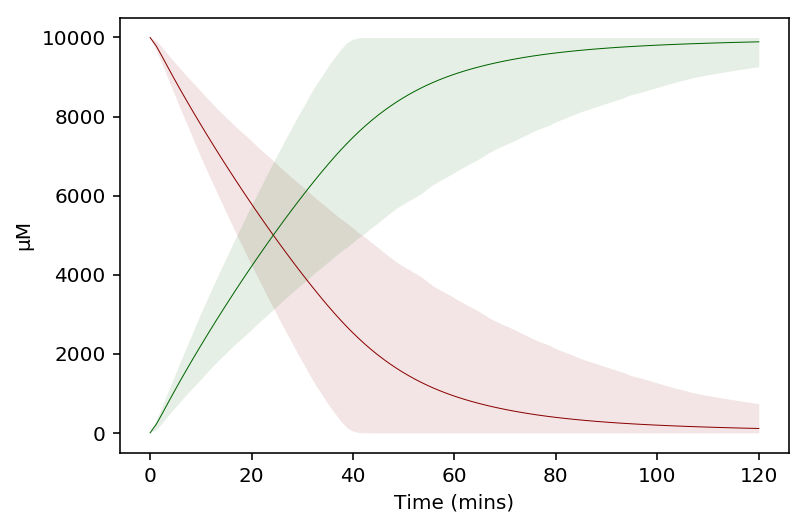

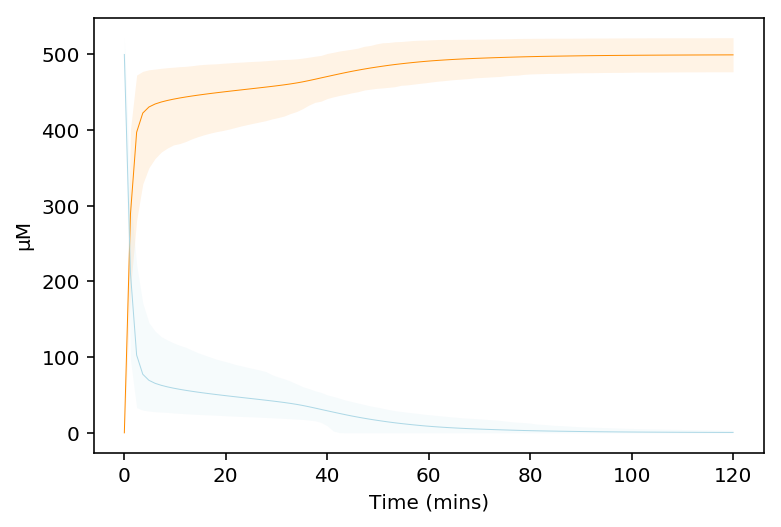

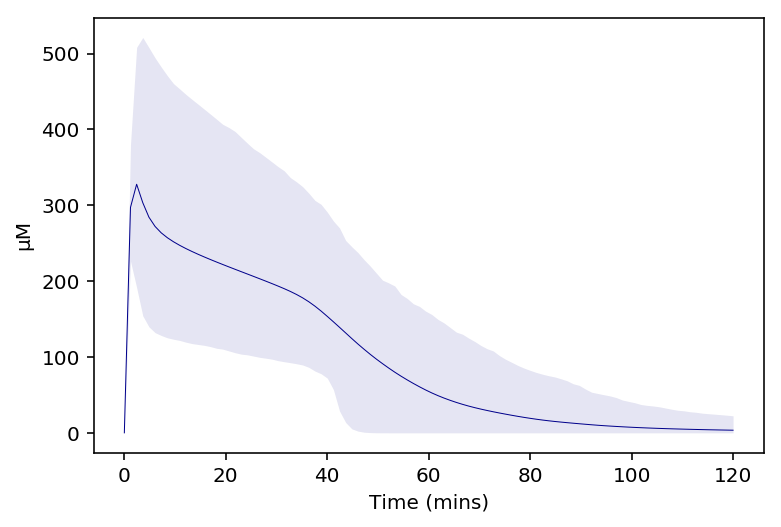

In [6]:
# Plot the confidence intervals
kinetics.plot_ci_intervals(['Aldehyde', 'Amine'], df95,
                           units=['μM', 'Time (mins)'],
                           colours=['darkred', 'darkgreen'],
                           alpha=0.1)
plt.show()

kinetics.plot_ci_intervals(['NADPH', 'NADP+'], df95,
                           units=['μM', 'Time (mins)'],
                           colours=['darkorange', 'lightblue'],
                           alpha=0.1)
plt.show()

kinetics.plot_ci_intervals(['GDL'], df95,
                           units=['μM', 'Time (mins)'],
                           colours=['darkblue'],
                           alpha=0.1)
plt.show()

## Metrics

In [7]:
# Specify MW and initiate the metrics object
enzyme_mws = {'gdh' : 31500,
              'redam' : 31155}

species_mws = {'Aldehyde' : 134.178,
               'Amine' : 175.3}

metrics = kinetics.Metrics(model,
                           substrate='Aldehyde',
                           product='Amine',
                           reaction_volume=1/1000,
                           enzyme_mws=enzyme_mws,
                           species_mws=species_mws)

In [8]:
print(metrics.biocatalyst_productivity())
print(metrics.space_time_yield())

12.771113841059028
20.850074480903142


## Sensitivity analysis

In [ ]:
log = ["redam_ki_aldehyde", "redam_km_amine", "redam_km_h2o", "redam_ki_amine"]
problem = kinetics.salib_problem(model, log=log)
sa_samples = kinetics.make_saltelli_samples(model, problem, 500, second_order=False)

In [7]:
outputs = kinetics.run_all_models(model, sa_samples)

100%|██████████| 12000/12000 [20:26<00:00,  9.78it/s]


In [8]:
concentration = 8000
substrate = 'Amine'
times = kinetics.get_time_to_concentration(model, outputs, concentration, substrate, mode='>=')
sobol = kinetics.analyse_sobal_sensitivity(problem, times, second_order=False, num_resample=100, conf_level=0.95)

/anaconda3/lib/python3.7/site-packages/kinetics/ua_and_sa/plotting.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.sort_values("ST", inplace=True, ascending=False)


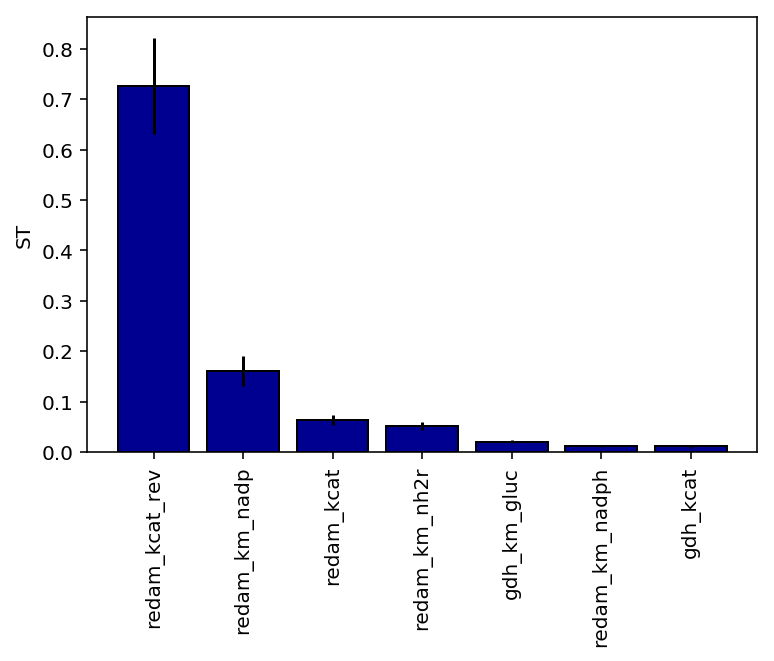

In [10]:
new_df = kinetics.remove_st_less_than(sobol, column='ST', less_than=0.01)
kinetics.plot_sa_total_sensitivity(new_df)
plt.savefig('sa_8000_amine.png', dpi=300)